In [1]:
import string
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import split, regexp_replace, lower, col, explode, regexp_extract
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.clustering import LDA, LocalLDAModel, DistributedLDAModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

In [2]:
df = spark.read.orc('data/dataframe.orc')
df.printSchema()

root
 |-- AcceptedAnswerId: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- ContentLicense: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- FavoriteCount: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- LastActivityDate: timestamp (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [3]:
df.count()

340838

In [4]:
# https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
df.select('Title', 'Body', 'Score', 'Tags', 'PostTypeId').show()

+--------------------+--------------------+-----+--------------------+----------+
|               Title|                Body|Score|                Tags|PostTypeId|
+--------------------+--------------------+-----+--------------------+----------+
|Coding the regres...|<p>Say I have 5 b...|    0|<r><regression><l...|         1|
|                null|<p>I recommend yo...|    2|                null|         2|
|Why dummy variabl...|<p>I was speaking...|    3|  <categorical-data>|         1|
|Binomial random v...|<p>I've been read...|    4|<chi-squared><bin...|         1|
| Analyze proportions|<p>I have a datas...|   13|    <r><multinomial>|         1|
|                null|<p>The terminolog...|    6|                null|         2|
|                null|<p>Perhaps he is ...|    3|                null|         2|
|                null|<p>Like Michelle ...|    3|                null|         2|
|Simulating financ...|<p>I would like t...|    1|<r><distributions...|         1|
|Multiple regres

In [5]:
# Get only questions
questions = df.filter(col('PostTypeId') == 1)
questions.count()

171236

In [6]:
tokenizer = Tokenizer(inputCol="Body", outputCol="words")
stopwords = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="stopwords")
punctuation = StopWordsRemover(inputCol=stopwords.getOutputCol(), outputCol="filtered", stopWords=[''] + list(string.punctuation))

stages = [tokenizer, stopwords, punctuation]
pipeline = Pipeline(stages=stages)

In [7]:
tokenizer

Tokenizer_fd24f6d38096

In [8]:
words = pipeline.fit(questions).transform(questions)

In [9]:
words.select('Body', 'words', 'filtered').show()

+--------------------+--------------------+--------------------+
|                Body|               words|            filtered|
+--------------------+--------------------+--------------------+
|<p>Say I have 5 b...|[<p>say, i, have,...|[<p>say, 5, binar...|
|<p>I was speaking...|[<p>i, was, speak...|[<p>i, speaking, ...|
|<p>I've been read...|[<p>i've, been, r...|[<p>i've, reading...|
|<p>I have a datas...|[<p>i, have, a, d...|[<p>i, dataset, c...|
|<p>I would like t...|[<p>i, would, lik...|[<p>i, like, gene...|
|<p>I am performin...|[<p>i, am, perfor...|[<p>i, performing...|
|<p>Suppose I want...|[<p>suppose, i, w...|[<p>suppose, want...|
|<p>A colleague of...|[<p>a, colleague,...|[<p>a, colleague,...|
|<p>The necessary ...|[<p>the, necessar...|[<p>the, necessar...|
|<p>Suppose a vari...|[<p>suppose, a, v...|[<p>suppose, vari...|
|<p>Suppose you ar...|[<p>suppose, you,...|[<p>suppose, usin...|
|<p>I am trying to...|[<p>i, am, trying...|[<p>i, trying, pr...|
|<p>If I am select...|[<p

In [10]:
words.printSchema()

root
 |-- AcceptedAnswerId: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- ContentLicense: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- FavoriteCount: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- LastActivityDate: timestamp (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [11]:
%%time
word_count = words.select(explode(col('filtered')).alias('word')).groupby('word').count().cache()

CPU times: user 5.87 ms, sys: 2.19 ms, total: 8.06 ms
Wall time: 184 ms


In [12]:
word_count.select('word').show()

+--------------------+
|                word|
+--------------------+
|                 ...|
|          $x_2$?</p>|
|               still|
|                $y$,|
|        estimate</p>|
|               input|
|         interaction|
|                hope|
|           traveling|
|              travel|
|     <p><strong>more|
|        package.</p>|
|           connected|
|                 art|
|            randomly|
|            incoming|
|           compared,|
|aforge.net(http:/...|
|               $x_1,|
|href="http://en.w...|
+--------------------+
only showing top 20 rows



In [13]:
%%time
word_count.sort(col('count').desc()).show(truncate=False)

+-------------+------+
|word         |count |
+-------------+------+
|<p>i         |151937|
|<span        |141991|
|</p>         |132687|
|data         |120309|
|model        |92518 |
|1            |90506 |
|0            |80010 |
|using        |70099 |
|one          |65569 |
|use          |63693 |
|</code></pre>|62856 |
|&lt;-        |61607 |
|like         |58256 |
|two          |58176 |
|test         |52410 |
|rel="nofollow|51207 |
|2            |50569 |
|<a           |50246 |
|different    |46631 |
|time         |45278 |
+-------------+------+
only showing top 20 rows

CPU times: user 1.55 ms, sys: 6.13 ms, total: 7.68 ms
Wall time: 5.24 s


In [14]:
word_count.sort(col('count').asc()).show(truncate=False)

+-----------------------------------------------------------+-----+
|word                                                       |count|
+-----------------------------------------------------------+-----+
|mix).                                                      |1    |
|rnorm(43,                                                  |1    |
|0.33564053                                                 |1    |
|lot..</p>                                                  |1    |
|-0.064328                                                  |1    |
|-1.23890500515482                                          |1    |
|not-quite-significant                                      |1    |
|empid,                                                     |1    |
|xn:</p>                                                    |1    |
|0.144669                                                   |1    |
|log-log?</p>                                               |1    |
|<p>also,the                                    

In [15]:
word_count.count()

1958634

In [16]:
VOCAB_SIZE = 100000
vocab = word_count.sort(col('count').desc()).limit(VOCAB_SIZE).toPandas()

In [17]:
vocab

,word,count
0,<p>i,151937
1,<span,141991
2,</p>,132687
3,data,120309
4,model,92518
...,...,...
99995,"1125l,",7
99996,year-over-year,7
99997,"(0.05,",7
99998,float32,7


<AxesSubplot:>

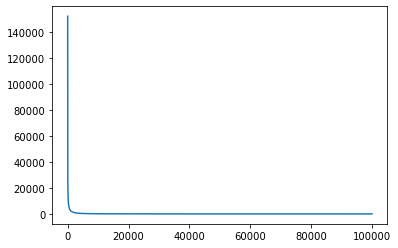

In [18]:
vocab['count'].plot()

<AxesSubplot:>

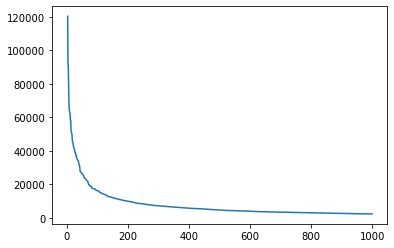

In [19]:
vocab.iloc[3:1000]['count'].plot()

In [20]:
vocab.head(10)

,word,count
0,<p>i,151937
1,<span,141991
2,</p>,132687
3,data,120309
4,model,92518
5,1,90506
6,0,80010
7,using,70099
8,one,65569
9,use,63693


In [21]:
lookup = dict(vocab.reset_index().set_index('word')['index'])

In [22]:
def bag_of_words(words: list) -> list:
    bag = np.zeros(VOCAB_SIZE, dtype=int)
    
    for word in words:
        if word in lookup:
            bag[lookup[word]] += 1
        
    return bag.tolist()

In [23]:
SparkBag = T.ArrayType(T.LongType())

count_vectorizer = F.udf(bag_of_words, SparkBag)

In [24]:
vectorized = words.withColumn('vector', count_vectorizer(F.col('filtered')))

In [25]:
vectorized.select('Title', 'Body', 'words', 'stopwords', 'filtered', 'vector').show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Title|                Body|               words|           stopwords|            filtered|              vector|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Coding the regres...|<p>Say I have 5 b...|[<p>say, i, have,...|[<p>say, 5, binar...|[<p>say, 5, binar...|[1, 0, 0, 0, 0, 2...|
|Why dummy variabl...|<p>I was speaking...|[<p>i, was, speak...|[<p>i, speaking, ...|[<p>i, speaking, ...|[1, 0, 0, 0, 0, 0...|
|Binomial random v...|<p>I've been read...|[<p>i've, been, r...|[<p>i've, reading...|[<p>i've, reading...|[1, 0, 0, 0, 0, 1...|
| Analyze proportions|<p>I have a datas...|[<p>i, have, a, d...|[<p>i, dataset, c...|[<p>i, dataset, c...|[1, 0, 0, 0, 1, 2...|
|Simulating financ...|<p>I would like t...|[<p>i, would, lik...|[<p>i, like, gene...|[<p>i, like, gene..

In [26]:
tf = CountVectorizer(inputCol=punctuation.getOutputCol(), outputCol="counts", minDF=2.0, vocabSize=50000)
idf = IDF(inputCol=tf.getOutputCol(), outputCol="features")

pipeline = Pipeline(stages=stages + [tf, idf])

In [27]:
stages + [tf, idf]

[Tokenizer_fd24f6d38096,
 StopWordsRemover_f047fd13788e,
 StopWordsRemover_700654d73bc0,
 CountVectorizer_119931c6c66d,
 IDF_31a4dad0182f]

In [28]:
tfidf = pipeline.fit(questions)

In [29]:
features = tfidf.transform(questions)

In [30]:
features.printSchema()

root
 |-- AcceptedAnswerId: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- ContentLicense: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- FavoriteCount: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- LastActivityDate: timestamp (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- counts: vector (nullable = true)
 |-- features: vector (nullable = true)



In [31]:
features.select('Body', 'words', 'stopwords', 'filtered', 'counts', 'features').show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Body|               words|           stopwords|            filtered|              counts|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|<p>Say I have 5 b...|[<p>say, i, have,...|[<p>say, 5, binar...|[<p>say, 5, binar...|(50000,[0,5,8,16,...|(50000,[0,5,8,16,...|
|<p>I was speaking...|[<p>i, was, speak...|[<p>i, speaking, ...|[<p>i, speaking, ...|(50000,[0,7,8,24,...|(50000,[0,7,8,24,...|
|<p>I've been read...|[<p>i've, been, r...|[<p>i've, reading...|[<p>i've, reading...|(50000,[0,5,10,13...|(50000,[0,5,10,13...|
|<p>I have a datas...|[<p>i, have, a, d...|[<p>i, dataset, c...|[<p>i, dataset, c...|(50000,[0,4,5,8,9...|(50000,[0,4,5,8,9...|
|<p>I would like t...|[<p>i, would, lik...|[<p>i, like, gene...|[<p>i, like, gene...|(50000,[0,2,8,11,..

In [32]:
row1 = features.take(1)

In [33]:
row1

[Row(AcceptedAnswerId=None, AnswerCount=0, Body='<p>Say I have 5 binary variables and 2 normal variables. I want to get the probability of success, say one of the variable 1 or 0, 1 for success. How can I do that?</p>\n\n<p>I tried <code>glm(A~B+C+D+E, binomial, data)</code> in R.</p>\n\n<p>$A$ is a binary variable for which I want to know the probability of success. \n$B$, $C$, $D$, $E$ are all binary variables. Am I doing right?</p>\n', CommentCount=2, ContentLicense='CC BY-SA 3.0', CreationDate=datetime.datetime(2012, 3, 6, 3, 46, 32, 870000), FavoriteCount=None, Id=24181, LastActivityDate=datetime.datetime(2019, 12, 5, 13, 39, 19, 240000), OwnerUserId=9633, PostTypeId=1, Score=0, Tags='<r><regression><logistic><categorical-data><binary-data>', Title='Coding the regresssion model with several binary variables', ViewCount=120, words=['<p>say', 'i', 'have', '5', 'binary', 'variables', 'and', '2', 'normal', 'variables.', 'i', 'want', 'to', 'get', 'the', 'probability', 'of', 'success,',

In [34]:
idfModel = tfidf.stages[-1]

In [35]:
inverseFreq = idfModel.idf

In [36]:
inverseFreq.argsort()

array([    0,     2,     3, ..., 48293, 26375, 43854])

In [37]:
tfidf.stages

[Tokenizer_fd24f6d38096,
 StopWordsRemover_f047fd13788e,
 StopWordsRemover_700654d73bc0,
 CountVectorizerModel: uid=CountVectorizer_119931c6c66d, vocabularySize=50000,
 IDFModel: uid=IDF_31a4dad0182f, numDocs=171236, numFeatures=50000]

In [38]:
cv = tfidf.stages[3]

In [39]:
vocab = cv.vocabulary

In [40]:
inverseFreq.argsort()[-20:]

array([37662, 36405, 31028, 39354, 42183, 32417, 18935, 26402, 20857,
       26435, 38966, 45377, 14815, 18787, 47698, 26504, 26506, 48293,
       26375, 43854])

In [41]:
np.array(vocab)[inverseFreq.argsort()[:20]]

array(['<p>i', '</p>', 'data', 'using', 'use', 'one', 'model', 'like',
       'two', 'know', 'want', '</code></pre>', '<a', 'different',
       'rel="nofollow', '<p>the', 'question', 'get', '1', 'test'],
      dtype='<U108')

## LDA

In [42]:
lda = LDA(k=10, featuresCol="counts", seed=1, optimizer='online', maxIter=100, optimizeDocConcentration=True)

In [43]:
#model = lda.fit(features)

In [44]:
#model.save('lda')

In [45]:
model = LocalLDAModel.load('lda')

In [55]:
ll = model.logLikelihood(features)
lp = model.logPerplexity(features)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -119081485.3627363
The upper bound on perplexity: 8.14193686951193


In [64]:
topics = model.describeTopics(50)
topics.show(truncate=70)

+-----+----------------------------------------------------------------------+----------------------------------------------------------------------+
|topic|                                                           termIndices|                                                           termWeights|
+-----+----------------------------------------------------------------------+----------------------------------------------------------------------+
|    0|[3, 0, 2, 7, 4, 91, 9, 37, 15, 12, 8, 17, 159, 191, 18, 92, 21, 22,...|[0.013141326666310163, 0.012424386127699442, 0.00861319325597771, 0...|
|    1|[6, 5, 26, 16, 34, 45, 61, 10, 69, 38, 247, 149, 56, 240, 251, 107,...|[0.06921664006423338, 0.06365012212467511, 0.03344424393537582, 0.0...|
|    2|[290, 911, 10, 1068, 1613, 5, 1732, 1487, 613, 105, 34, 885, 243, 1...|[0.03387200541473163, 0.019301730211782497, 0.011214982561593291, 0...|
|    3|[4, 0, 2, 3, 25, 24, 7, 19, 29, 14, 9, 13, 15, 8, 18, 12, 50, 78, 5...|[0.01474952352962792, 

In [47]:
categorized = model.transform(features)
categorized.select('Title', 'topicDistribution').show(truncate=70)

+----------------------------------------------------------------------+----------------------------------------------------------------------+
|                                                                 Title|                                                     topicDistribution|
+----------------------------------------------------------------------+----------------------------------------------------------------------+
|            Coding the regresssion model with several binary variables|[0.0022535909771216624,0.17188763823549483,0.0011567043893364174,0....|
|   Why dummy variables rather than one "factor" variable in modelling?|[0.0033929181750065383,0.0021703276873766783,0.00174149241075022,0....|
|          Binomial random variables versus chi-square for A/B testing?|[0.12137970785037135,0.05064127244349029,0.010864431247392423,0.348...|
|                                                   Analyze proportions|[0.1365842293355517,0.027755828970609565,0.02104989227097788,0.4

In [48]:
categorized.printSchema()

root
 |-- AcceptedAnswerId: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- ContentLicense: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- FavoriteCount: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- LastActivityDate: timestamp (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- counts: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = tru

## Interpreting LDA

In [65]:
topicsDF = topics.toPandas()

In [66]:
_, _, _, vectorizerModel, _ = tfidf.stages

In [67]:
vectorizerModel.vocabulary[:10]

['<p>i', '<span', '</p>', 'data', 'model', '1', '0', 'using', 'one', 'use']

In [68]:
vocab = np.array(vectorizerModel.vocabulary)

In [69]:
topicsDF['words'] = topicsDF.termIndices.apply(lambda x: vocab[x])

In [70]:
for t in topicsDF.words:
    print(t)
    print('\n\n')

['data' '<p>i' '</p>' 'using' 'model' 'training' 'use' 'set'
 'rel="nofollow' 'like' 'one' '<a' 'learning' 'features' 'different'
 'dataset' 'want' 'number' 'feature' 'image' 'used' 'class' 'get' 'test'
 'network' 'input' 'classification' 'neural' 'values' 'algorithm' 'know'
 'output' 'problem' 'function' 'two' 'train' 'way' 'new' 'trying' 'find'
 'machine' 'accuracy' 'best' 'also' '<p>the' 'noreferrer"><img'
 'understand' "<p>i'm" 'anova' '<p><a']



['0' '1' '0,' '2' '3' '1,' '4' '</code></pre>' '5' '1l,' '***' '6' '2l,'
 '7' '8' '10' '(intercept)' '0l,' 'data' '9' 'well' '2,' 'value' '&lt;'
 'std.' '12' '11' '0.1' 'df' 'estimate' 'error' '0.001' '&gt;' '3l,'
 '0.05' '0.' '---' 'degrees' '0.01' '&lt;-' '15' '<p>i' '3,' '13'
 'freedom' 'codes:' 'datasets' '<pre><code>' 'signif.' 'b']



['na' '0.00' '</code></pre>' '0.0' '1.00' '1' '0.2' 'questions:</p>'
 '0.01' 'b' '3' '0.5' 'c' '2' '1.0' '3rd' 'median' 'mean' '<pre><code>'
 'plant' '4' 'tests,' 'data' 'min.' '0.1' 'study,' '\\hat' '

In [49]:
from pyspark.ml.functions import vector_to_array

In [50]:
topicDist = categorized.withColumn('topicArray', vector_to_array(col('topicDistribution'))) \
           .select('Title', *[col('topicArray')[i] for i in range(model.getK())]).cache()

In [79]:
# print top 10 documents for Topic 8
topicDist.orderBy('topicArray[7]', ascending=False) \
           .limit(20) \
           .select('Title', 'topicArray[7]').show(truncate=120)

+------------------------------------------------------------------------------------------------------------+------------------+
|                                                                                                       Title|     topicArray[7]|
+------------------------------------------------------------------------------------------------------------+------------------+
|                                                                    Taking the difference of two MCMC chains|0.9954692277129832|
|    Why does significance not equal validity? Why can't I stop a test as soon as it has significant results?|0.9950423499337309|
|                                                         One-sample Wilcoxon test result does not make sense|0.9947278191159741|
|                                                      Statistical testing against empirical density function|0.9940187262769482|
|                                   How to compare the distances or divergence between two

## Cross Validation

In [ ]:
num_topics = [5, 20, 50]

paramGrid = ParamGridBuilder() \
    .addGrid(lda.k, num_topics) \
    .build()

In [ ]:
modelVal = lda.fitMultiple(features, paramMaps = paramGrid)